**Predicting which Round of a Tennis Tournament in which a Match is Played**

**Introduction:** <p> Our goal for this project is to be able to predict which round of a tournament a tennis match occured, from top 128 to finals, based on relevant match data.</p> <p> The first round of a tournament begins with 128 players and after each match the number of players remaining is halved. This continues until quarterfinals(QF), then to semi-finals(SF), and ending with the grand finals(F).</p> <p>This includes data from both the winners and losers and the length of a match. This data was gathered from the 2021 matches played by athletes part of the Association of Tennis Professionals (ATP).</p>



In [2]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(dplyr)
library(rvest)
library(tidymodels)
library(GGally)
library(ISLR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Warning message:
“package ‘rvest’ was built under R version 4.0.2”
Loading required package: xml2


Attach

**Step 1:** <p> Read in the data, and select the potential columns of data that will be used. Since we want to investigate matches that are five sets long, filter for '5' in the 'best_of' column. Finally, split the data into training and testing sets, so that the accuracy of our model can be predicted later. 

In [3]:
tennis_data <- read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2021.csv") %>%
select(winner_name, loser_name, round, best_of, minutes, w_ace, w_svpt, winner_rank, w_bpSaved, l_ace, l_svpt, l_bpSaved, loser_rank) %>%
filter(best_of == 5)
tennis_data

tennis_split <- initial_split(tennis_data, prop = .75, strata = round)  
tennis_train <- training(tennis_split)   
tennis_test <- testing(tennis_split)

Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



winner_name,loser_name,round,best_of,minutes,w_ace,w_svpt,winner_rank,w_bpSaved,l_ace,l_svpt,l_bpSaved,loser_rank
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Novak Djokovic,Jeremy Chardy,R128,5,91,9,57,1,0,3,86,7,61
Frances Tiafoe,Stefano Travaglia,R128,5,111,6,87,64,4,8,83,4,60
Reilly Opelka,Yen Hsun Lu,R128,5,115,18,84,38,1,3,92,5,1009
Taylor Fritz,Albert Ramos,R128,5,203,11,143,31,11,6,142,6,46
Stan Wawrinka,Pedro Sousa,R128,5,96,7,74,18,0,2,91,9,107
Marton Fucsovics,Marc Polmans,R128,5,252,7,151,55,9,3,160,15,126
Corentin Moutet,John Millman,R128,5,225,1,148,71,3,3,154,6,39
Milos Raonic,Federico Coria,R128,5,95,17,70,14,2,2,98,11,92
Emil Ruusuvuori,Gael Monfils,R128,5,226,4,195,86,17,13,162,7,11


**Step 2:** <p>The data is currently separated into winner and loser stats. For it to be more useful, we need to combine those stats to make them into totals or averages, depending on which makes more sense for the type of variable. Before we do so, we get rid of the 'NA' rows using the drop_na() function. Then we can compute all the summary statistics in the mutate() functions. We also need to convert the round column into numerical data as it is much easier to work with. We can do so by using the mutate() function once again, creating a column named 'round_n', and using the recode() function within it to assign numerical values to each of the rounds we currently have. In this case we've assigned 1 to be the round of 128, and 7 to be the final, and the respective values in between. Finally, we select round_n, minutes, total_ace, avg_rank, and total_bpSaved as these will be variables that we believe could be influenced by the round of the tournament in which the match is being played.

In [4]:
tennis_comb <- tennis_train %>%
                drop_na() %>%
                mutate(total_ace = w_ace + l_ace) %>%
                mutate(avg_rank = ((winner_rank + loser_rank)/2)) %>%
                mutate(total_bpSaved = w_bpSaved + l_bpSaved) %>%
                mutate(round_n = recode(round, "R128" = 1, "R64" = 2, "R32" = 3, "R16" = 4, "QF" = 5, "SF" = 6, "F" = 7)) %>%
                select(round_n, minutes, total_ace, avg_rank, total_bpSaved)
tennis_comb

round_n,minutes,total_ace,avg_rank,total_bpSaved
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,91,12,31.0,7
1,111,14,62.0,8
1,203,17,38.5,17
1,96,9,62.5,9
1,252,10,90.5,24
1,95,19,53.0,13
1,226,17,48.5,24
1,159,11,72.5,18
1,156,56,51.0,10


**Step 3:** <p> To create a summary of this rather large dataset we can group by the round, which is essentially what we're interested in. Then we can summarize the data so that each round is only associated with one row - this allows us to see whether there might be a trend. Then, so that it's easily legible, we want to arrange it so that the data is ordered by the round during which the tournament was played, in this case from the round of 128 (round_n = 1) to the final (round_n = 7). 

In [5]:
tennis_group <- tennis_comb %>%
                group_by(round_n) %>%
                summarise_if(is.numeric, mean) %>%
                arrange(round_n)
tennis_group

round_n,minutes,total_ace,avg_rank,total_bpSaved
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,157.1710,18.98446,80.12694,11.740933
2,154.9574,19.72340,69.21277,12.191489
3,153.8776,17.34694,43.18367,10.346939
4,152.9583,15.91667,30.58333,10.916667
5,167.0000,17.30000,21.00000,10.600000
6,174.6667,19.66667,13.50000,10.000000
7,151.0000,17.33333,3.00000,9.666667


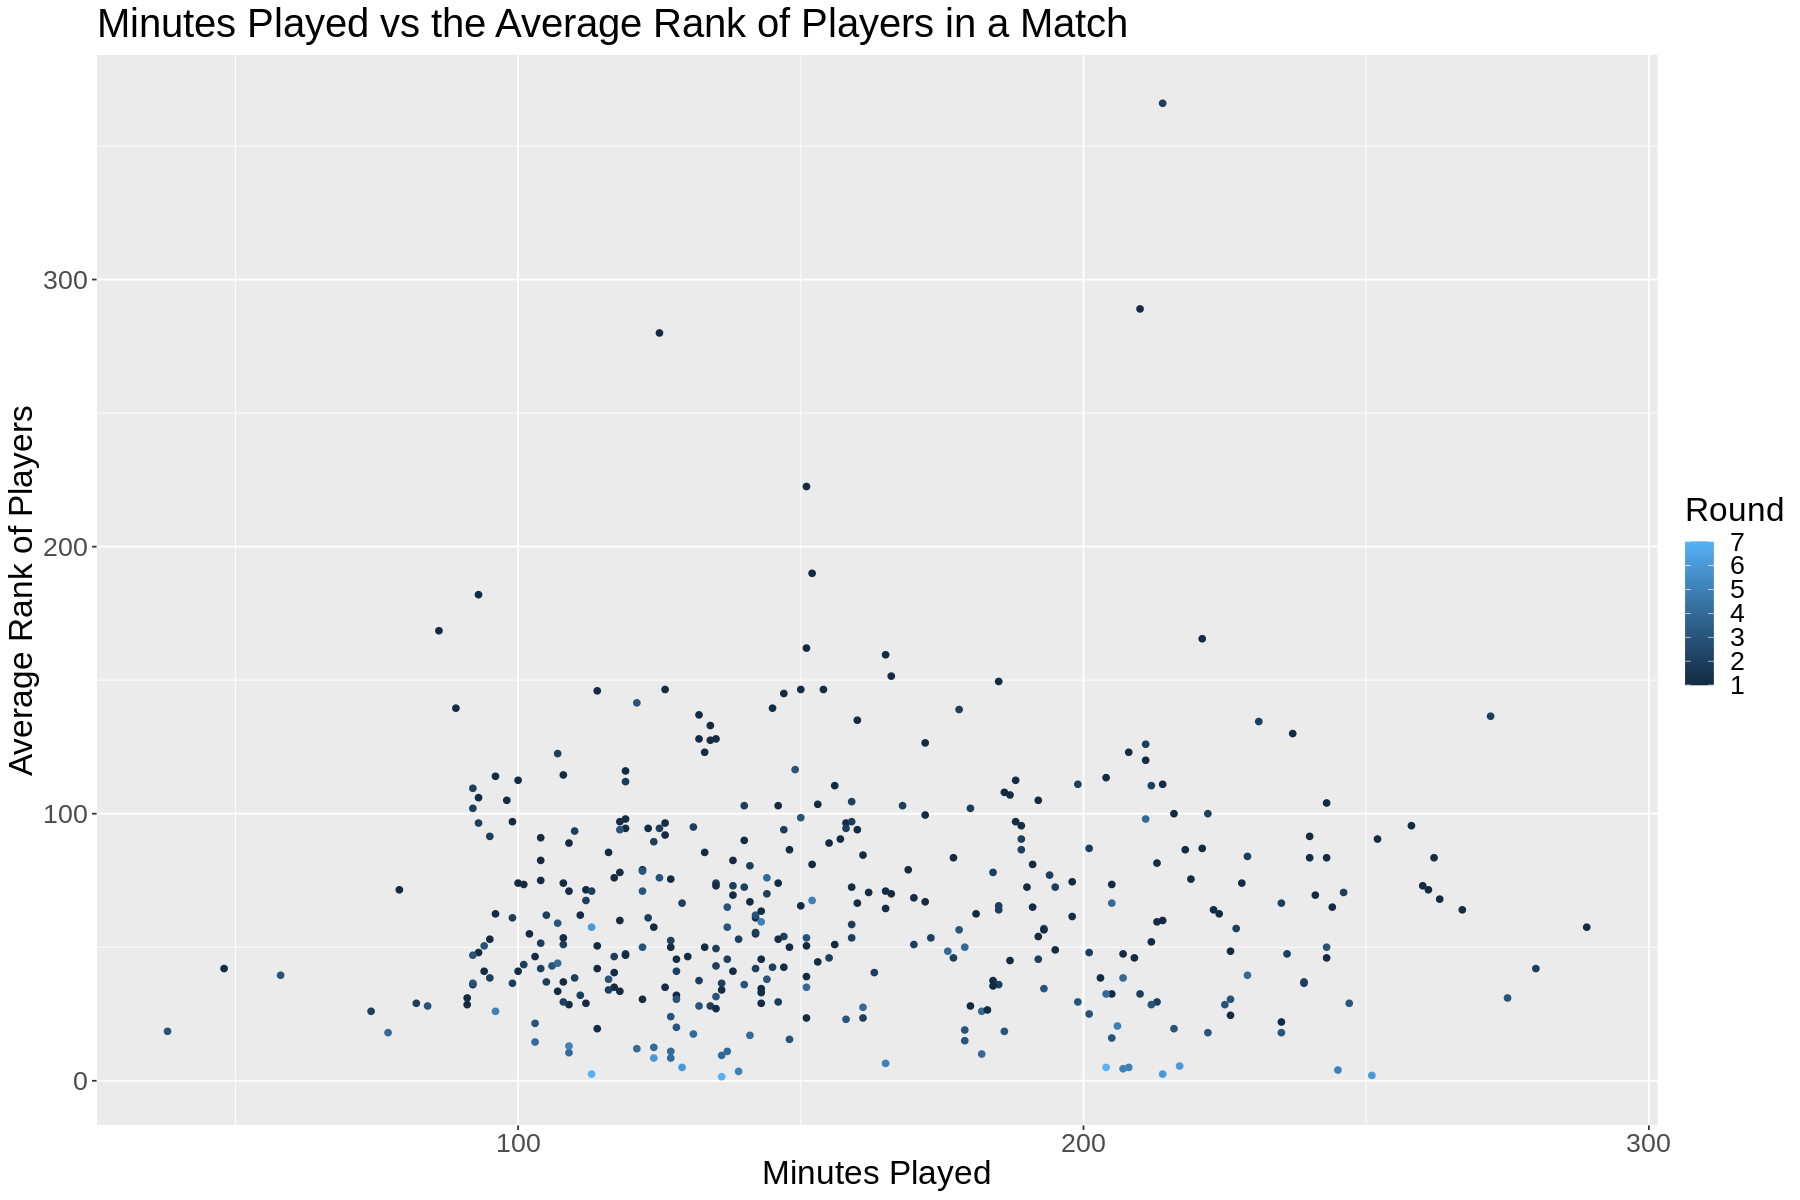

In [6]:
options(repr.plot.width = 15, repr.plot.height = 10) 

tennis_plot <- ggplot(tennis_comb, aes(x = minutes, y = avg_rank)) + 
                geom_point(aes(color = round_n)) +
                xlab("Minutes Played") +
                ylab("Average Rank of Players") +
                labs(color = "Round") +
                theme(text = element_text(size = 20)) + 
                ggtitle("Minutes Played vs the Average Rank of Players in a Match")
                
tennis_plot

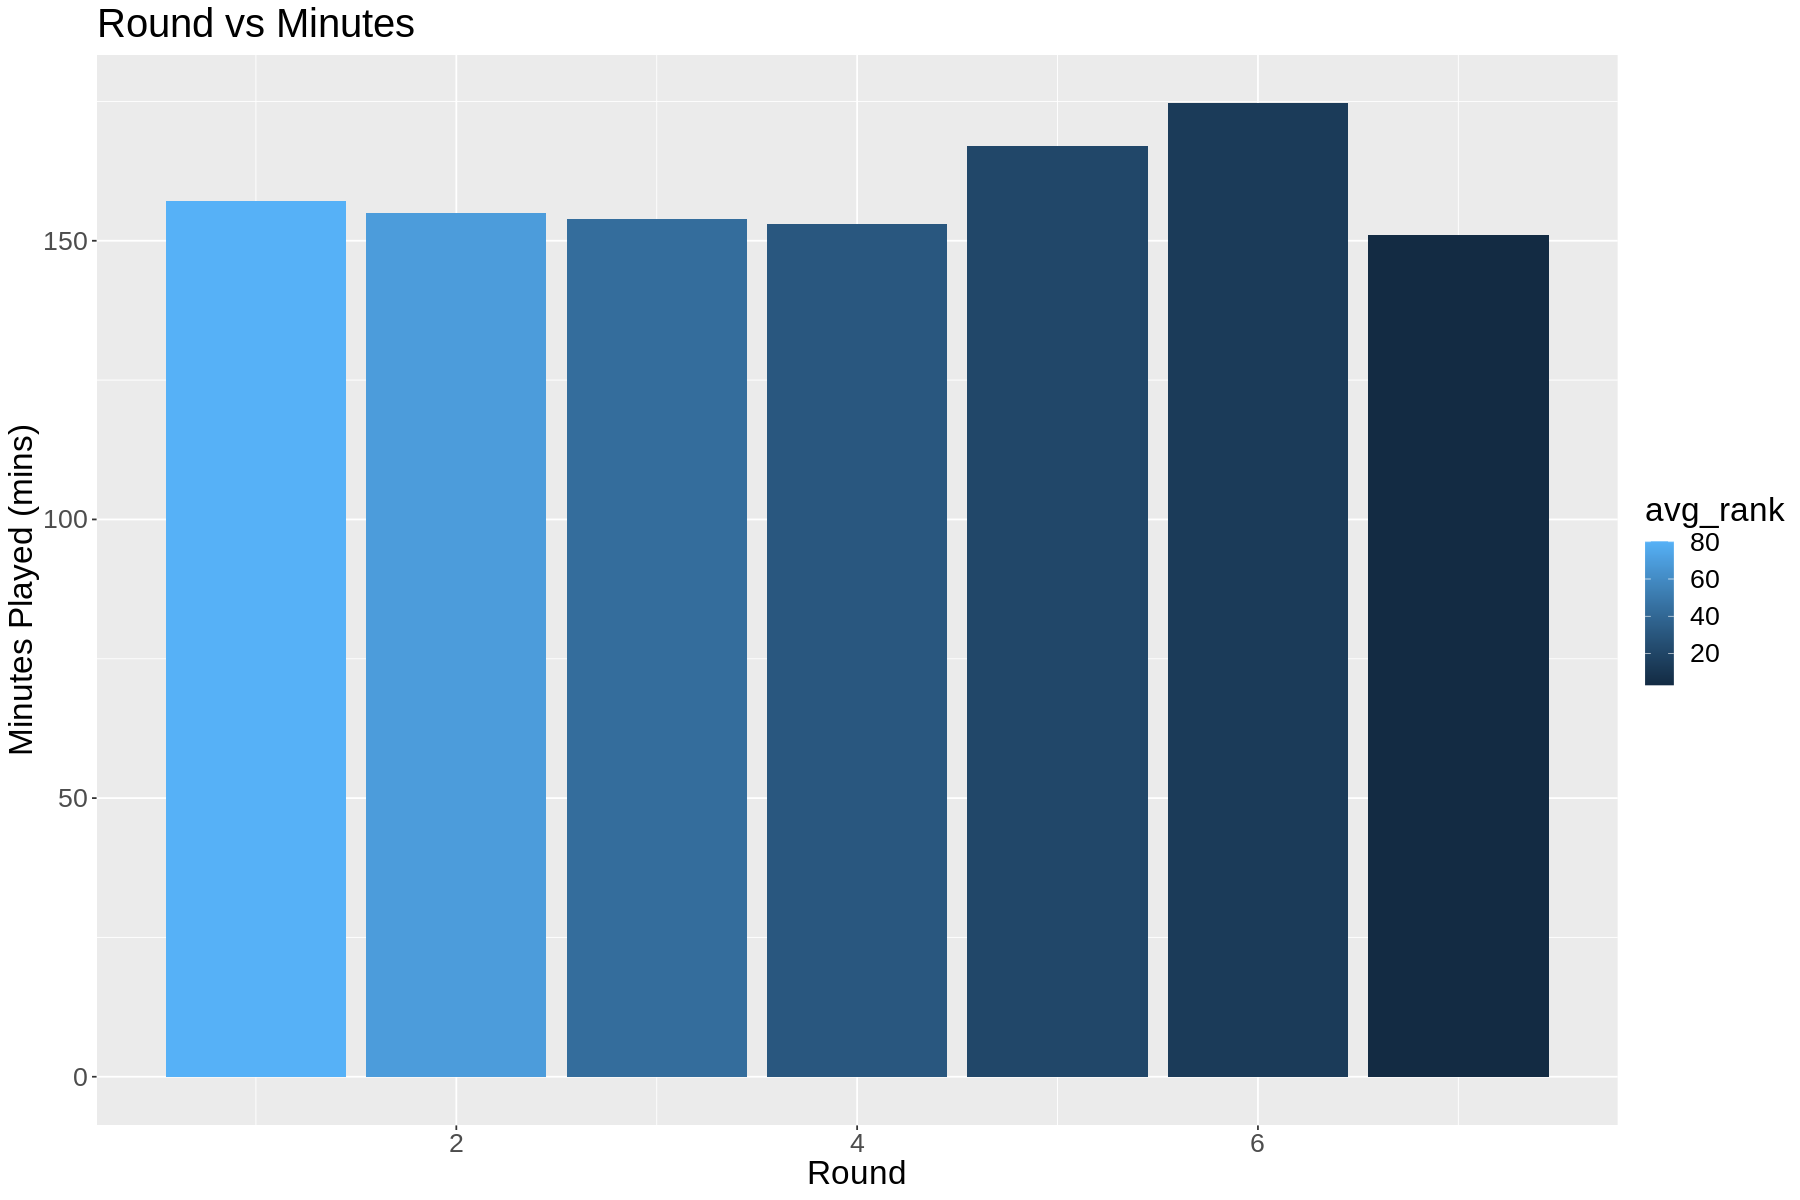

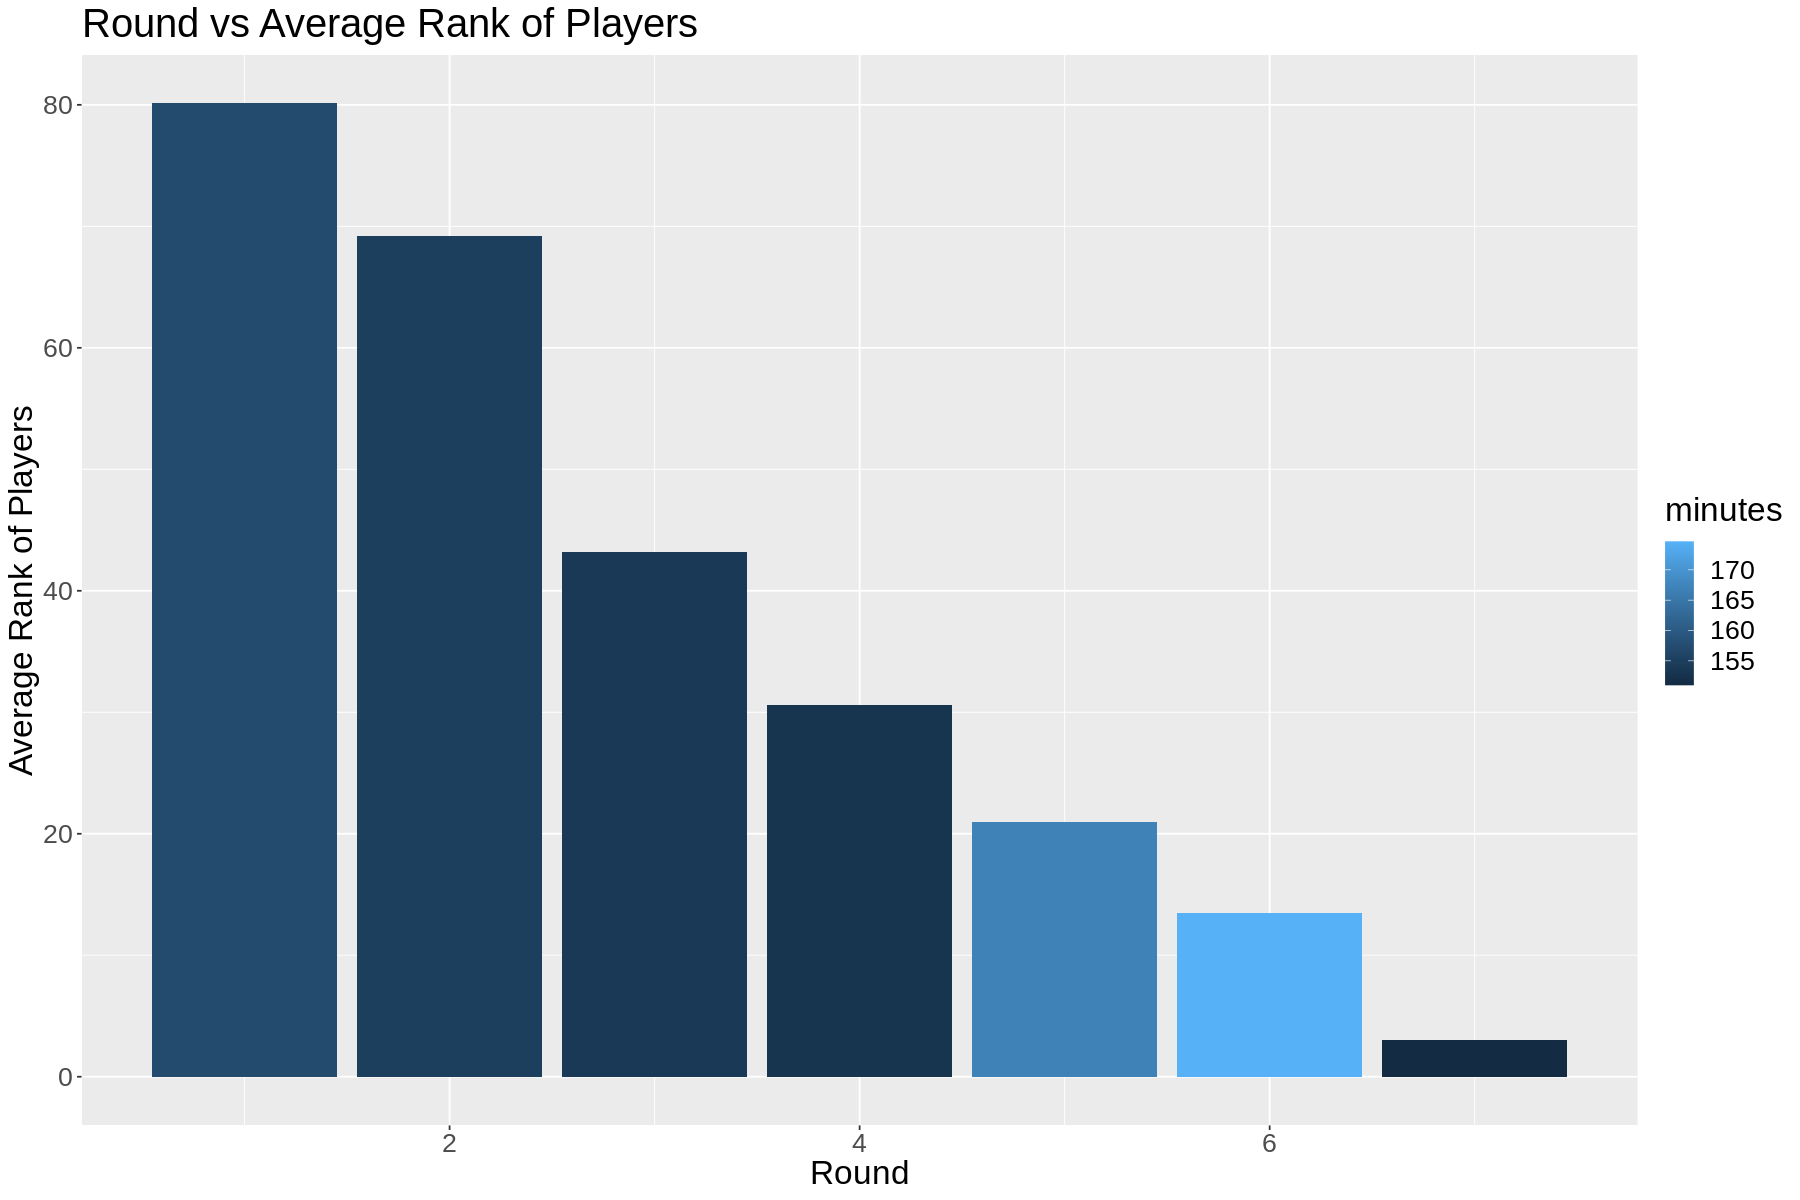

In [7]:
options(repr.plot.width = 15, repr.plot.height = 10) 

round_vs_minutes_bar <- ggplot(tennis_group, aes(x = round_n, y = minutes, fill = avg_rank)) + 
    geom_bar(stat = "identity") +
    xlab("Round") +
    ylab("Minutes Played (mins)") +
    theme(text = element_text(size = 20)) + 
    ggtitle("Round vs Minutes")
round_vs_minutes_bar


round_vs_avg_rank_bar <- ggplot(tennis_group, aes(x = round_n, y = avg_rank, fill = minutes)) + 
    geom_bar(stat = "identity") +
    xlab("Round") +
    ylab("Average Rank of Players") +
    theme(text = element_text(size = 20)) + 
    ggtitle("Round vs Average Rank of Players")
round_vs_avg_rank_bar

As we grouped our dataset by round, we have summarized our dataset called tennis_group. Using tennis_group, we made two bar charts of visualizations by putting "round_n" on x-axis. This help us to see the how "minutes" and "average rank" related to different rounds, which gives us a rough idea of what we are looking for when doing the data analysis. We plan to analyze and predict what round of match does a new given point belong by using classification. When we saw these two graphs, we noticed that as that the bigger number the round is, the average ranks of players are smaller. This means that higher ranking players tend to play to further rounds since our data indicates that round 128 is round 1 here and round final is round 7 here. Also, I put color to fill out the third variable in each bar chart. In the first one graph we see that even though the minutes of different rounds are similar, we see darker color in bigger number of rounds. Also in the second graph, it seems like low ranking players play longer time comparing to high ranking players as the color goes darker as well. Therefore through these two visualizations we may assume that high ranking players play slightly less time and they are most likely going into further rounds.